# Fuel type and Vapor Pressure Deficit (VPD) regional relationships on Burned Area in the Western United States

## Final Project for EESC G6901: Research Computing for the Earth Sciences

Code by **Caroline Juang**, c.juang@columbia.edu

Columbia University, December 2020

## Project Goals

Fire activity in the western United States (US) presents [a clear danger to human life and infrastructure](https://earthobservatory.nasa.gov/images/147443/record-setting-fires-in-colorado-and-california), establishing a need to study the variables that may influence fire. 

One measurable characteristic of fire activity is the area burned by a fire. Burn area that results from fire is affected by the climate, ignition availability, and fuel availability. In this notebook, I will explore both the fuel availability (**question 1**) and the climate (**question 2**). 

In previous research, it has been shown that a clear relationship exists between log of burned area and VPD in forested ecosystems across the western United States (US) [1, 2]. To investigate this relationship further, I want to ask two questions:

1. **What is the contribution of forest and non-forest ecosystems to fire in the western US?** 

The log burned area-VPD relationship is strongest in forested ecosystems. However, the western US is not only made up of forests, so I want to explore the relationships of forest and non-forest ecosystems and their contribution to burn area. What areas should we be focusing on forest burn area, and what regions should focused on non-forest burn area? 

I hypothesize that in the prairie ecosystems in the central western US, grasslands make up a large part of the vegetation and will subsequently be affected by non-forest burn area than forested burn area.

2. **What kind of relationship exists between burn area and VPD by region?** 

I will explore the correlation of the 3-month sum of burned area in each region and their associated averaged VPD, only for the largest fires in the 9 ecoregions of the western US. I hypothesize that this relationship will have higher correlation R-values in largely-forested ecosystems in the analysis of the forested burn area vs. VPD, and will be weaker in non-forest burn area vs. VPD. 

The relationship to emerge is likely to be more linear than exponential, since there is possibly another environmental limit to the exponential increase, like a limit in fuel or ignition that would allow large fires to continue to burn exponentially with increasing VPD.

**References**

[1]: Williams, A. P., Seager, R., Macalady, A. K., Berkelhammer, M., Crimmins, M. A., Swetnam, T. W., ... & Hryniw, N. (2015). Correlations between components of the water balance and burned area reveal new insights for predicting forest fire area in the southwest United States. International Journal of Wildland Fire, 24(1), 14-26. https://doi.org/10.1071/WF14023

[2]: Seager, R., Hooks, A., Williams, A. P., Cook, B., Nakamura, J., & Henderson, N. (2015). Climatology, variability, and trends in the US vapor pressure deficit, an important fire-related meteorological quantity. *Journal of Applied Meteorology and Climatology, 54*(6), 1121-1141. https://doi.org/10.1175/JAMC-D-14-0321.1

## Setup

In [1]:
# import
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# suppress output warnings
import warnings
warnings.simplefilter(action='ignore')

### Import the data

In [2]:
# download the datasets needed
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/wildfire/burnarea_combined.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/US_ForestType_Ruefenacht/forest_type_frac.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/ea.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/es.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/ecoregions/epa_level2.nc'

--2020-12-03 19:09:43--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/wildfire/burnarea_combined.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 129.236.14.15
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-12-03 19:09:43--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/US_ForestType_Ruefenacht/forest_type_frac.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 129.236.14.15
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-12-03 19:09:44--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/ea.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 

**The NetCDF data is imported here as 12km gridded datasets over the western United States**, projected in USA Contiguous Albers Equal Area Conic, USGS
* Burn area is the monthly burned area of each grid cell (km^2) from 1984 to 2018.
* "EA" is the monthly average of vapor pressure in the atmosphere (hPa) from 1901 to 2020.
* "ES" is the monthly average of saturation vapor pressure (hPa) in the atmosphere from 1901 to 2020.
* The ecoregion data is a set of 9 gridded ecoregions that divide up the western US. One of the ecoregions is dropped because it contains no data for this region of interest. 
* Forested area is the fraction of each grid cell that is covered by 5 types of forest.

In [3]:
# import fire data and get variables
burnarea_data = xr.open_dataset('burnarea_combined.nc')
# burnarea = burnarea_data.burnarea
X = burnarea_data.X
Y = burnarea_data.Y

# import ecoregion data
ecoregion_data = xr.open_dataset('epa_level2.nc')
# drop the bad ecoregion
ecoregion_data = ecoregion_data.sel(province=[0,1,2,3,5,6,7,8,9], drop=True)
ecoregion_legend = ecoregion_data.ecoregion
epa_l2 = ecoregion_data.epa_level2

# import forested area
forest_type_data = xr.open_dataset('forest_type_frac.nc')
ftype = forest_type_data.ftype

In [4]:
# limit dataset to the years with complete data, 1984 to 2018
burnarea_data = burnarea_data.burnarea.loc["1984-01-15":"2018-12-15"]
time_str = burnarea_data.time

* After importing vapor pressure and saturation vapor pressure, we calculate vapor pressure deficit (VPD) using the following formula, where $e_s$ is saturation vapor pressure, $e_a$ is vapor pressure of the atmosphere, and $T_a$ is the temperature of the atmosphere:

VPD $ = e_s(T_a) - e_a $

In [5]:
# import vapor pressure data
ea_data = xr.open_dataset('ea.nc')
# import saturation vapor pressure data
es_data = xr.open_dataset('es.nc')

# calculate vapor pressure deficit
vpd = es_data.es - ea_data.ea

# limit dataset to the same timeframe as burnarea data
vpdcurrent = vpd.loc["1984-01-15":"2018-12-15"]

## 1. What is the contribution of forest and non-forest ecosystems to fire in the western US?

Many analyses look at forested burn area since there are clearer climate-fire signals in forested areas. Since not every region of the western US is forested due to different climate and topographic conditions, I want to see where forested burn area matters and where non-forested burned area matters.

### Burned area in forests and not in forests
I use our fractional forest NetCDF gridded dataset to get the burned area associated with forest and non-forest grid cells.

In [6]:
# storage
forest = np.zeros((len(Y), len(X)), np.single)

# add up the forest percentages for each forest type
for index,number in enumerate(ftype):
    forest = forest + forest_type_data.forest_type_frac[index,:,:]

# remove forest_type_data netCDF
forest_type_data = None

# get burned area in forest
burnforest = burnarea_data * forest

In [7]:
# get non-forested burned area using fractional difference
burnxforest = burnarea_data * (1-forest)

I want to get maps of the sum of burned area, so I will sum the data along the `time` dimension, so I have a 2-D grid of burned area.

In [8]:
# get time-sum spatial burn area
burnforesttime = burnforest.sum(dim='time')
burnxforesttime = burnxforest.sum(dim='time')

# mask the array to remove plotting where there is 0 burned area
burnforesttime2 = np.ma.masked_where(burnforesttime.values==0, burnforesttime)
burnxforesttime2 = np.ma.masked_where(burnxforesttime.values==0, burnxforesttime)

#### Figure 1. Spatial patterns of forest and non-forest burned area, summed for 1984-2018.
**Here's where I visualize burned area in forests and non-forests on a map, summed over the entire dataset in time.** I set both of the scales to the same maximum to make it easier to see which areas have greater forest burned area, and which areas have greater non-forest burned area, summed over all years 1984 to 2018. 

We can see that areas with high contribution of forest burned area differ from areas of non-forest burned area.

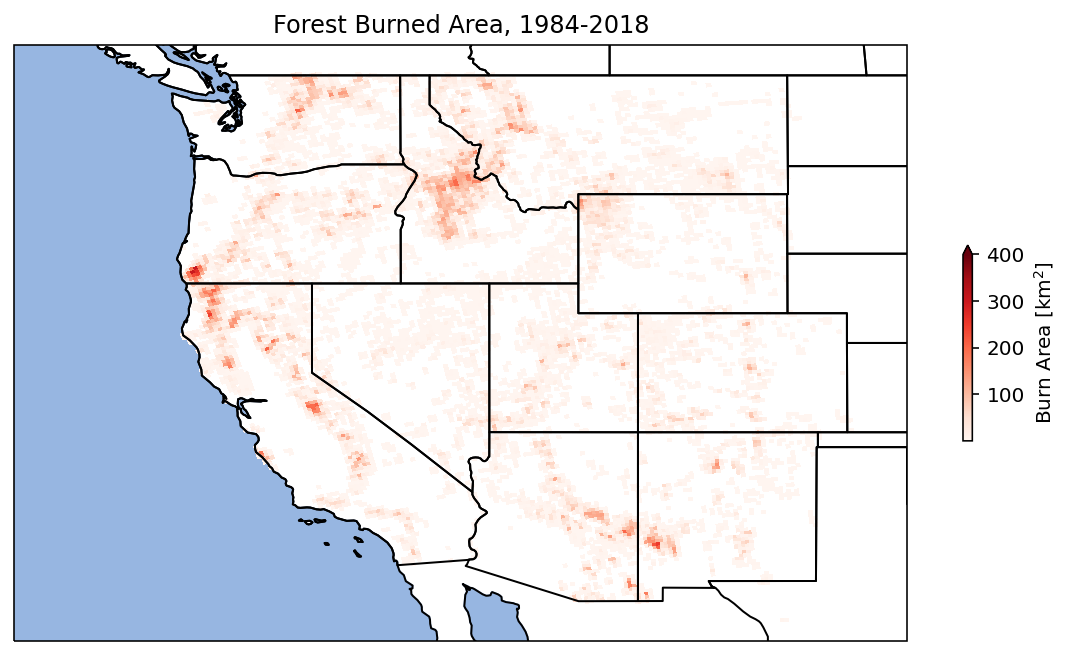

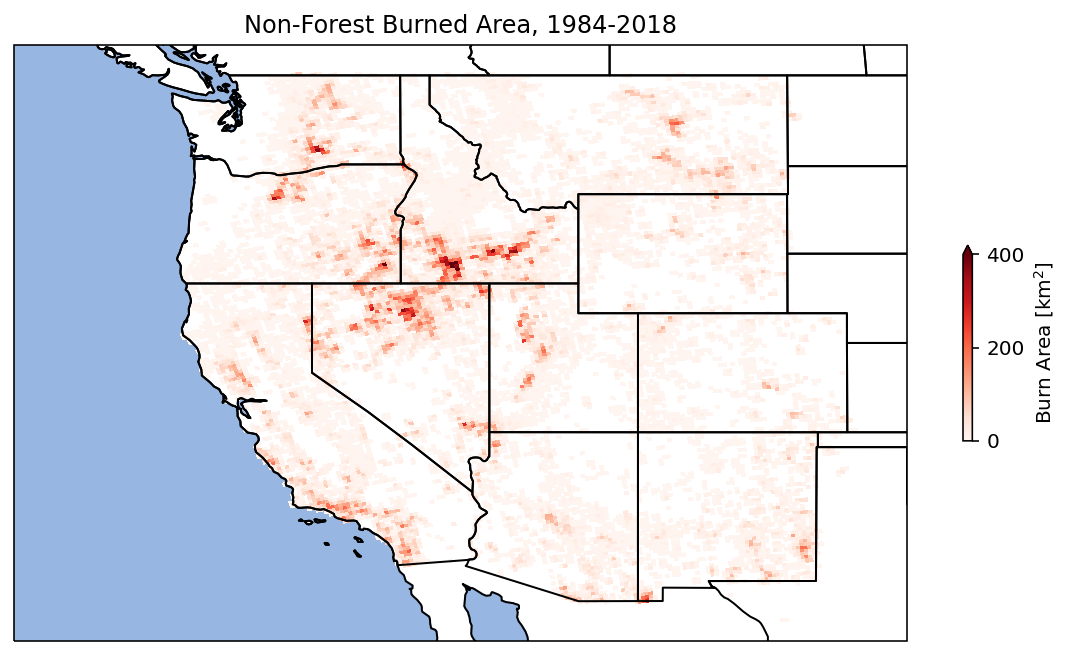

In [9]:
# visualize forested and non forested burned area

# define map extent
extent = [-130,-100,30,50]

# plot
fig, ax1 = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})
# setup map
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, edgecolor='black', zorder=9)
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax1.add_feature(cfeature.OCEAN)

# plot data
burnmapfo = ax1.pcolormesh(burnforesttime.X, burnforesttime.Y, burnforesttime2, cmap='Reds', vmax=400,
                           transform=ccrs.epsg(5070))
# decorate
ax1.set_title('Forest Burned Area, 1984-2018')

bar1 = fig.colorbar(burnmapfo, ax=ax1, shrink=0.30, extend='max')
bar1.set_label('Burn Area [km$^2$]')

plt.savefig('figures/1forestburnedarea.png')

# plot 
fig, ax2 = plt.subplots(figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree()})
ax2.set_extent(extent, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, edgecolor='black', zorder=9)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax2.add_feature(cfeature.OCEAN)

# plot data
burnmapxfo = ax2.pcolormesh(burnxforesttime.X, burnxforesttime.Y, burnxforesttime2, cmap='Reds', vmax=400,
                            transform=ccrs.epsg(5070))
# decorate
ax2.set_title('Non-Forest Burned Area, 1984-2018')
bar2 = fig.colorbar(burnmapxfo, ax=ax2, shrink=0.30, extend='max')
bar2.set_label('Burn Area [km$^2$]')

# output
plt.savefig('figures/1nonforestburnedarea.png')

### Visualize (coarse) annual burned area
Instead of summing the burned area over the `time` dimension, I resample the data annually and sum it over the `X` and `Y` dimensions so we can see the sum of burned area by year for both forest and non-forest parts. The data is coarse because we are using a 12km grid.

In [10]:
# resample to get burned area by year
burnforest_all = burnarea_data.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])
burnforest_y = burnforest.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])
burnxforest_y = burnxforest.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])

In [11]:
# setup
# years in dataset
yrmin = 1984
yrmax = 2018

# make list of years
years = np.arange(yrmin, yrmax+1)
months = np.arange(1,12+1) # months
nyears = yrmax-yrmin

In [12]:
# make DataFrame of the annual burn area for plotting
df = pd.DataFrame({'years': years, 'forest': burnforest_y.values, 
                   'non-forest': burnxforest_y.values, 
                   'all burn area': burnforest_all.values})

In [13]:
# calculate the linear line of best fit
burnallm, burnallb = np.polyfit(df.years, df['all burn area'], 1)
burnfom, burnfob = np.polyfit(df.years, df.forest, 1)
burnxfom, burnxfob = np.polyfit(df.years, df['non-forest'], 1)

#### Figure 2: Annual burned area in the western United States, 1984-2018.
**Here I visualize the annual burned area for forest and non-forest area over time.** The graph is stacked to show the total burned area and the components that are contributions from forest burned area (in green) and non-forest burn area (in blue). The trend of only forest burned area is a dotted green line, and the linear trend of only non-forest burned area is in blue. 

The figure below shows that more of the total annual burned area comes from burning of non-forest ecosystems than forest ecosystems. However, both components are large and contribute to a worrying, linear positive trend in area burned in the western US between 1984 and 2018. 

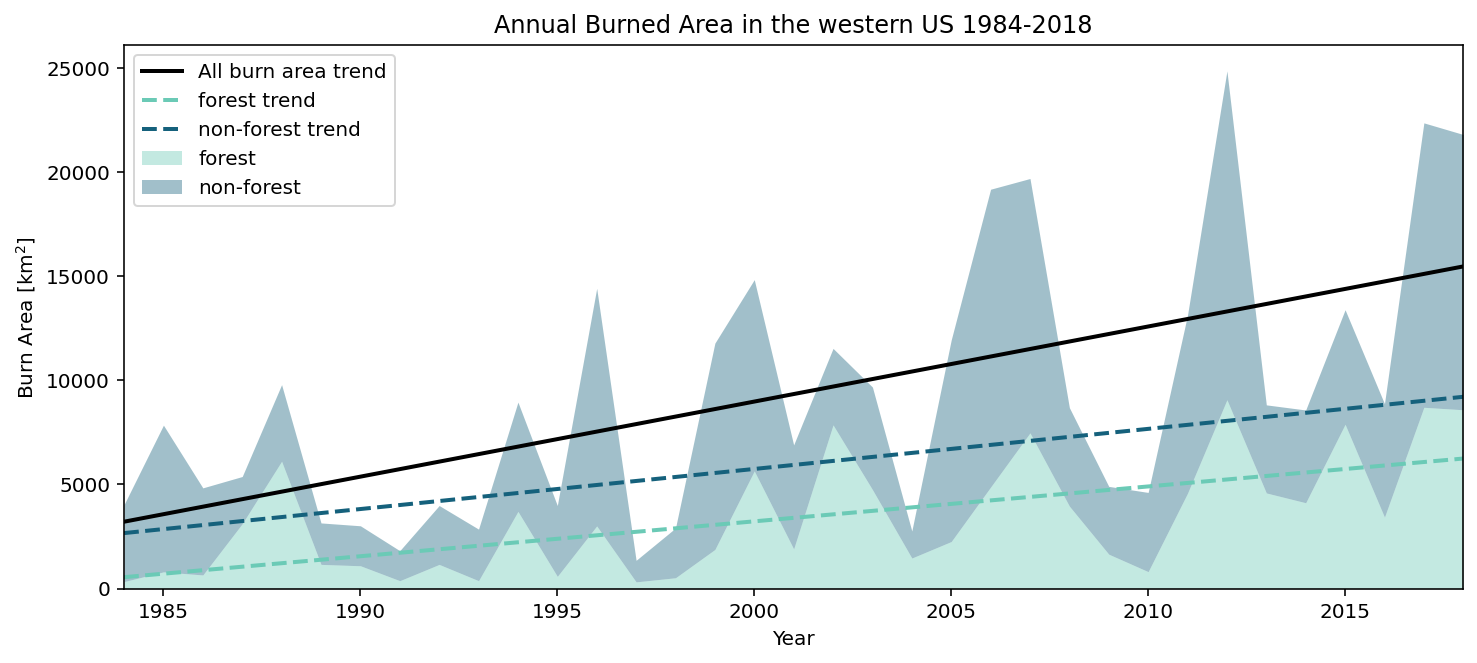

In [14]:
# colors
palette = ['#6bcab6', '#15617c']

# plot data
fig, ax = plt.subplots(figsize=(12,5))
df.plot.area(x='years', y=['forest','non-forest'], color=palette, alpha=0.4, linewidth=0, ax=ax)

# plot line of best fit
ax.plot(years, (burnallm*years + burnallb), color='k', linewidth=2, label='All burn area trend')
ax.plot(years, (burnfom*years + burnfob), '--', color=palette[0], linewidth=2, label='forest trend')
ax.plot(years, (burnxfom*years + burnxfob), '--', color=palette[1], linewidth=2, label='non-forest trend')

# decorate
ax.legend(loc='upper left')
ax.set_title('Annual Burned Area in the western US 1984-2018')
ax.set_ylabel('Burn Area [km$^2$]')
ax.set_xlabel('Year');
ax.set_xlim([1984,2018])

# output
plt.savefig('figures/2annualburnedarea.png')

### Burned Area by Ecoregion
The spatial patterns of our forest and non-forest contributions to burned area are distinct regions (seen in **Figure 1**). Therefore, I take a look at monthly forest and non-forest burned area by ecoregions defined by the EPA. I chose to use Level II ecoregions because they provide a sub-continental view of the ecosystems spanning the western US. This graphic provides the names and numbers of the ecoregions, color-coded with the regions on the map. This map was created in QGIS.

![Western US level II ecoregions](Ecoregions_key_small.png)

Below is a look at the gridded ecoregion netCDF file. In each 12km grid cell, the fractional coverage of the ecoregion is in each ecoregion layer.

In [15]:
epa_l2

<xarray.DataArray 'epa_level2' (province: 9, Y: 208, X: 155)>
[290160 values with dtype=float32]
Coordinates:
  * X        (X) float64 -2.353e+06 -2.341e+06 ... -5.172e+05 -5.052e+05
  * Y        (Y) float64 3.172e+06 3.16e+06 3.148e+06 ... 6.995e+05 6.875e+05
Dimensions without coordinates: province
Attributes:
    long_name:  fraction of grid cell within each EPA level-2 ecoregion
    units:      unitless

### Get rolling seasonal burned area

The goal of this part is to get rolling seasonal (3-month sums) of burned area data for each ecoregion. I first split the burned data into the different regions, and get the regional sum, then perform a rolling sum on each 3-month period.

In [16]:
# create container for month sums of burned area
month_burnfo = np.zeros((len(time_str), len(epa_l2)))
month_burnxfo = np.zeros((len(time_str), len(epa_l2)))

# get monthly burned data by region
for index, region in enumerate(epa_l2):
    tmpburnarea_fo = burnforest * region
    tmpburnarea_xfo = burnxforest * region
    month_burnfo[:, index] = tmpburnarea_fo.sum(dim=('Y','X'))
    month_burnxfo[:, index] = tmpburnarea_xfo.sum(dim=('Y','X'))
    
# create new DataArrays
month_burnfo = xr.DataArray(month_burnfo, coords=[time_str, ecoregion_legend], dims=['time', 'ecoregion'])
month_burnxfo = xr.DataArray(month_burnxfo, coords=[time_str, ecoregion_legend], dims=['time', 'ecoregion'])

In [17]:
# check out monthly rolling fire threshold in burn area by month
burnfomoroll = month_burnfo.rolling(time=3).sum()
burnxfomoroll = month_burnxfo.rolling(time=3).sum()

#### Figure 3: Rolling 3-month sum of area burned by ecoregion
**This graph shows the seasonal (3-month) burned area across the 9 ecoregions, with starting month on the x-axis and the sum burned area on the y-axis.** The graphs layer non-forest burned area (in blue) on top of forest-burned area (in green) to compare the contribution of type of fuel to total burned area. As expected, desert and prairie regions have more non-forest burned area. The cold deserts have the greatest non-forest burned area, likely because they are grasslands, supporting my hypothesis. The area of greatest non-forest burned area is in the Cold Deserts, which perhaps is [affected by invasive species](https://www.fs.usda.gov/treesearch/pubs/39188) that alter the fire activity in the region.

The area of greatest forest burned area is the Western Cordillera, mountain belts in the northern parts of the western US. These mountains are likely densely forested with trees and are easily affected by fire both possibly because of the surplus of vegetation and inaccessibility to fire suppression efforts.

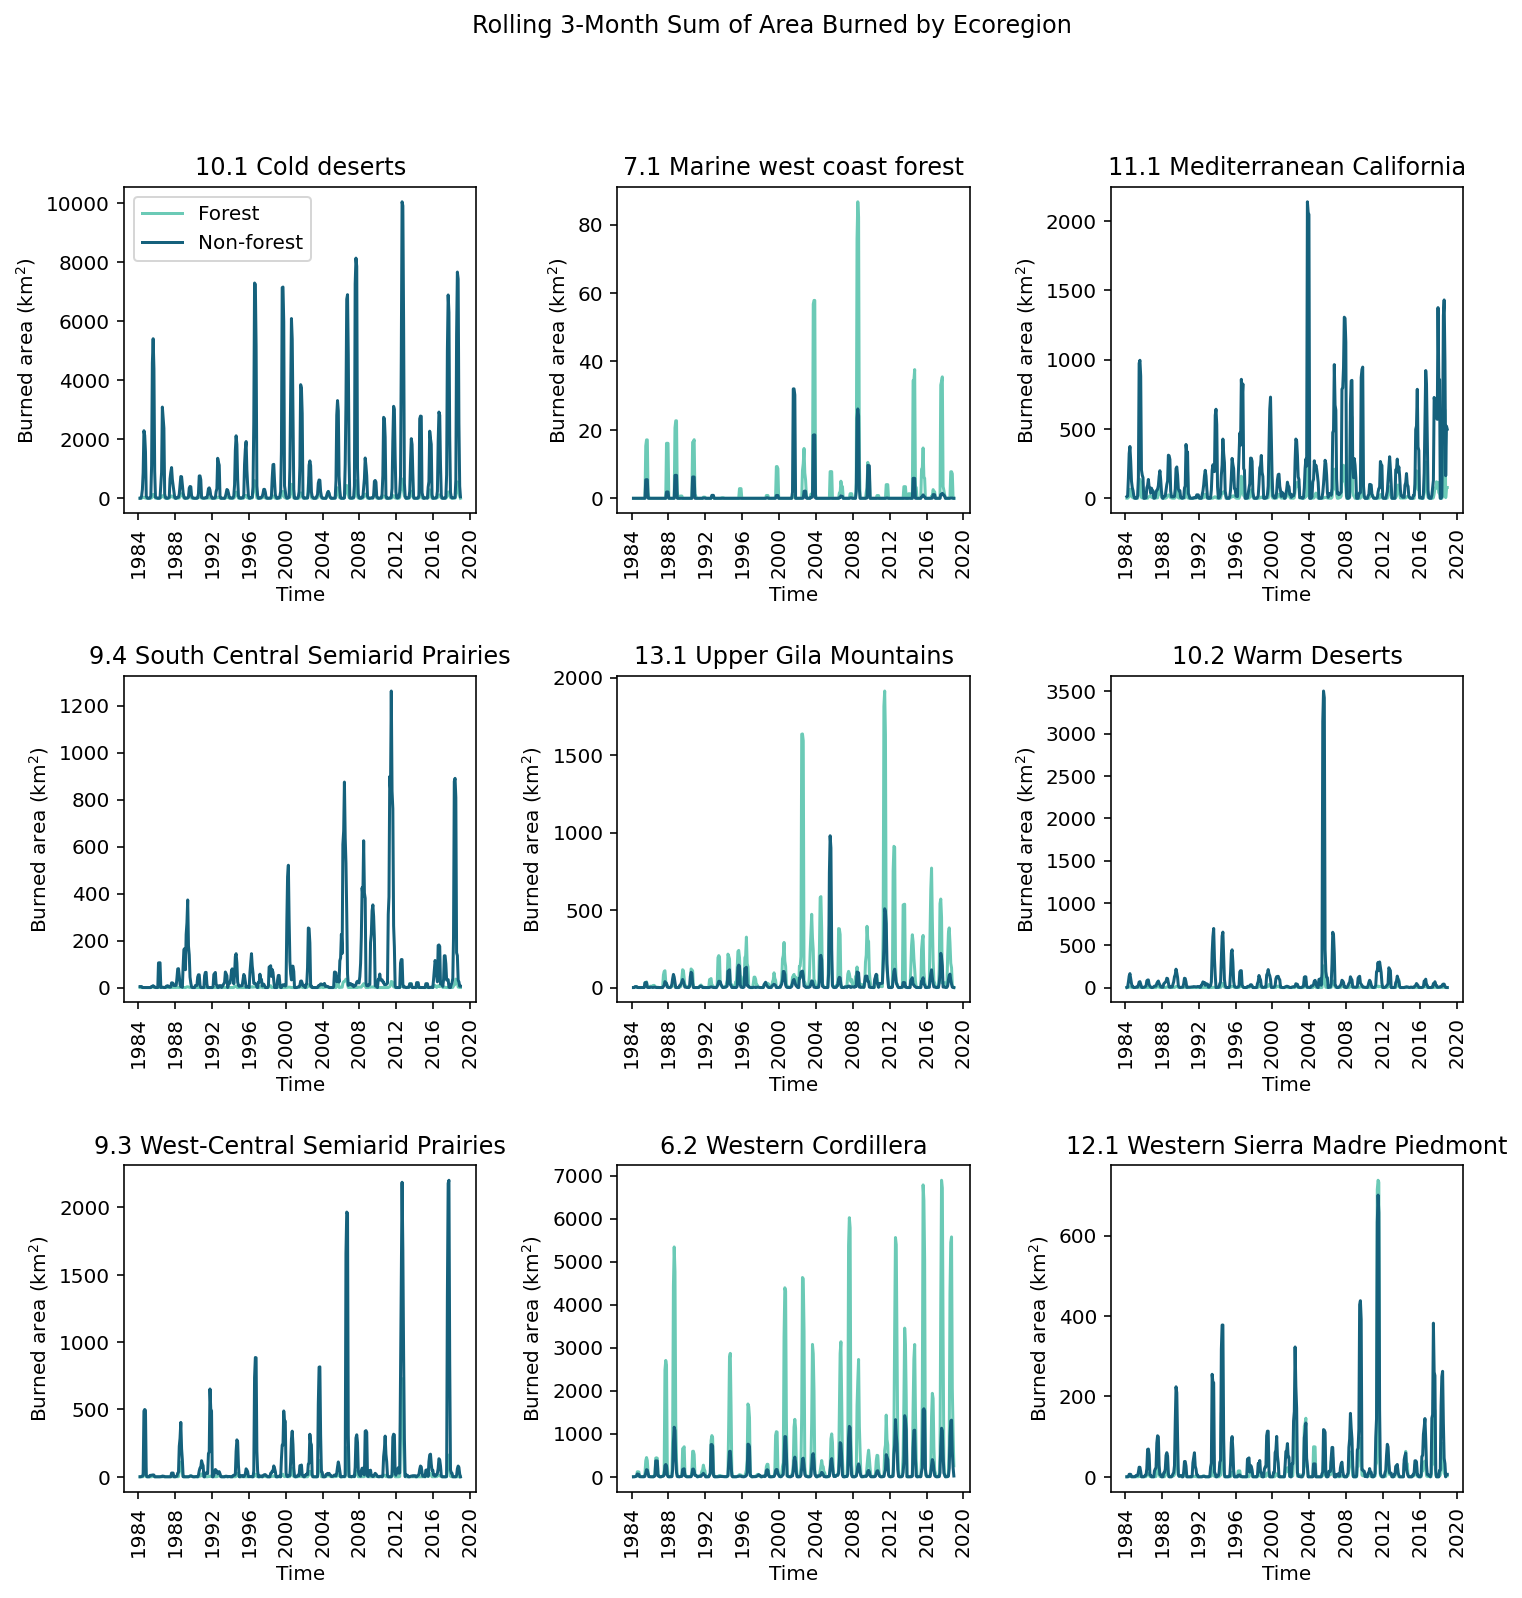

In [18]:
# plot the monthly rolling fire threshold for forested area

# plot
fig, ax = plt.subplots(3,3, figsize=(12,12))

counter = 0
for index in range(0,3):
    for jndex in range(0,3):
        ax[index,jndex].plot(burnfomoroll.time, burnfomoroll.isel(ecoregion=counter), color=palette[0], zorder=2, label='Forest')
        ax[index, jndex].plot(burnxfomoroll.time, burnxfomoroll.isel(ecoregion=counter), color=palette[1], zorder=3, label='Non-forest')
        counter+=1
        
# decorate plots
ax[0,0].set_title('10.1 Cold deserts')
ax[0,1].set_title('7.1 Marine west coast forest')
ax[0,2].set_title('11.1 Mediterranean California')
ax[1,0].set_title('9.4 South Central Semiarid Prairies')
ax[1,1].set_title('13.1 Upper Gila Mountains')
ax[1,2].set_title('10.2 Warm Deserts')
ax[2,0].set_title('9.3 West-Central Semiarid Prairies')
ax[2,1].set_title('6.2 Western Cordillera')
ax[2,2].set_title('12.1 Western Sierra Madre Piedmont')

# iterate and plot labels
for index in range(0,3):
    for jndex in range(0,3):
        plt.setp(ax[index,jndex].get_xticklabels(), rotation=90, horizontalalignment='center')
        ax[index,jndex].set_xlabel('Time')
        ax[index,jndex].set_ylabel('Burned area (km$^2$)')
        
ax[0,0].legend(loc='upper left')
plt.suptitle('Rolling 3-Month Sum of Area Burned by Ecoregion')
plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.4)
# output
plt.savefig('figures/3rolling3monthsumecoregion.png')

## 2. What kind of relationship exists between burn area and VPD by region?
For this analysis, I focus on seasonal burned area and its associated seasonal VPD, where a season is a rolling 3-month period of time. Will a more linear relationship emerge instead of exponential when I focus only on the largest seasonal burned area periods?

I first adjust the monthly VPD to get the average monthly VPD per ecoregion.

In [19]:
# get monthly VPD by region

# preallocate storage
month_vpd = np.zeros((len(time_str), len(epa_l2)))

# get monthly average
for index, region in enumerate(epa_l2):
    # area-weighted average
    # sum(new adjusted climate values)/sum(sum of all values in region map) 
    tmpvar = vpdcurrent * region
    month_vpd[:, index] = tmpvar.sum(dim=('Y','X')) / region.sum()
    
# create new DataArray
month_vpd = xr.DataArray(month_vpd, coords=[time_str, ecoregion_legend], dims=['time', 'ecoregion'])

In [20]:
# get the seasonal VPD with 3-month rolling periods of time
vpdrolling = month_vpd.rolling(time=3).mean()

In each ecoregion, I choose to look at the 3-month rolling seasons that have the top 25% largest burned areas. This number was selected as a starting point, and could be changed in the future.

In [21]:
# get quantile of fires for each region
quanvalue = 0.75
# check out monthly rolling fire threshold in burn area by month
tmpquantfo = burnfomoroll.where(burnfomoroll > 0).quantile(quanvalue, dim='time')
tmpquantxfo = burnfomoroll.where(burnfomoroll > 0).quantile(quanvalue, dim='time')

# use quantile to create a mask for the dataset
# iterate through the dataset
tmpmaskfo = burnfomoroll >= tmpquantfo
tmpmaskxfo = burnxfomoroll >= tmpquantxfo

Now that I have only the periods with the top 25% burned areas for each region, I get the associated VPD for each region. 

In [22]:
# get masked burn area
tmpburnfo = burnfomoroll.where(tmpmaskfo, drop=True)
tmpburnxfo = burnxfomoroll.where(tmpmaskxfo, drop=True)

# get masked vpd
tmpvpdfo = vpdrolling.where(tmpmaskfo, drop=True)
tmpvpdxfo = vpdrolling.where(tmpmaskxfo, drop=True)

Now that I prepared both the arrays for burned area and VPD, I can analyze the relationship using a Pearson Correlation for each region, using all the 3-month burned area sums vs. 3-month VPD included in each region. I store the values for the R-value and the p-value.

In [23]:
# get correlation of VPD and burned area
# storage
corrfo = np.zeros((len(epa_l2)))
sigfo = np.zeros((len(epa_l2)))
corrxfo = np.zeros((len(epa_l2)))
sigxfo = np.zeros((len(epa_l2)))

# get the line of best fit for the graphs
# storage for parameters
mfo = np.zeros((len(epa_l2)))
bfo = np.zeros((len(epa_l2)))
mxfo = np.zeros((len(epa_l2)))
bxfo = np.zeros((len(epa_l2)))

for index, region in enumerate(epa_l2):
    # forest
    tmpvpd = tmpvpdfo[:, index].dropna(dim='time')
    tmpburn = tmpburnfo[:, index].dropna(dim='time')
    tmpstats = scipy.stats.pearsonr(tmpvpd, tmpburn)
    corrfo[index] = tmpstats[0]
    sigfo[index] = tmpstats[1]
    mfo[index], bfo[index] = np.polyfit(tmpvpd, tmpburn, 1)
    # non-forest
    tmpvpd = tmpvpdxfo[:, index].dropna(dim='time')
    tmpburn = tmpburnxfo[:, index].dropna(dim='time')
    tmpstats = scipy.stats.pearsonr(tmpvpd, tmpburn)
    corrxfo[index] = tmpstats[0]
    sigxfo[index] = tmpstats[1]
    mxfo[index], bxfo[index] = np.polyfit(tmpvpd, tmpburn, 1)

# store values in regional correlations
# define storage for correlation by region
#corr_vpd[jndex,:] = corr
#corrsig_vpd[jndex,:] = sig

In [24]:
# list of regions
regionnames = ('10.1 Cold deserts', '7.1 Marine west coast forest', '11.1 Mediterranean California', 
               '9.4 South Central Semiarid Prairies', '13.1 Upper Gila Mountains', '10.2 Warm Deserts',
              '9.3 West-Central Semiarid Prairies', '6.2 Western Cordillera', '12.1 Western Sierra Madre Piedmont')

# get significance of forest and non-forest correlations
print('P-value for forest correlations')
for name, pvalue in zip(regionnames, sigfo):
    print(f'{name:40} ==> {pvalue:10.2}')
print('\nP-value for non-forest correlations')
for name, pvalue in zip(regionnames, sigxfo):
    print(f'{name:40} ==> {pvalue:10.2}')

P-value for forest correlations
10.1 Cold deserts                        ==>    0.00036
7.1 Marine west coast forest             ==>       0.46
11.1 Mediterranean California            ==>       0.22
9.4 South Central Semiarid Prairies      ==>    0.00078
13.1 Upper Gila Mountains                ==>      0.048
10.2 Warm Deserts                        ==>       0.36
9.3 West-Central Semiarid Prairies       ==>     0.0022
6.2 Western Cordillera                   ==>    1.9e-08
12.1 Western Sierra Madre Piedmont       ==>       0.39

P-value for non-forest correlations
10.1 Cold deserts                        ==>    1.3e-16
7.1 Marine west coast forest             ==>       0.87
11.1 Mediterranean California            ==>     0.0004
9.4 South Central Semiarid Prairies      ==>     0.0043
13.1 Upper Gila Mountains                ==>       0.15
10.2 Warm Deserts                        ==>     0.0022
9.3 West-Central Semiarid Prairies       ==>    1.3e-12
6.2 Western Cordillera             

#### Figure 4: 3-Month Sum Burned Area vs. Monthly VPD for Top 25% of Burned Area Periods for each Region
**This graph shows the relationship between 3-month rolling burned area vs. 3-month rolling VPD, but only the top 25% largest burned area periods for each region.** While I expected the region to have more of a linear relationship between burned area and VPD, especially for forested ecoregions, visually I see exponential relationships emerge, especially when you look at the Upper Gila Mountains and the Western Cordillera. Strong non-forested burned area-VPD relationships are seen in Mediterranean California and West-Central Semiarid Prairies, which would be important to explore to see what could be causing these relationships.

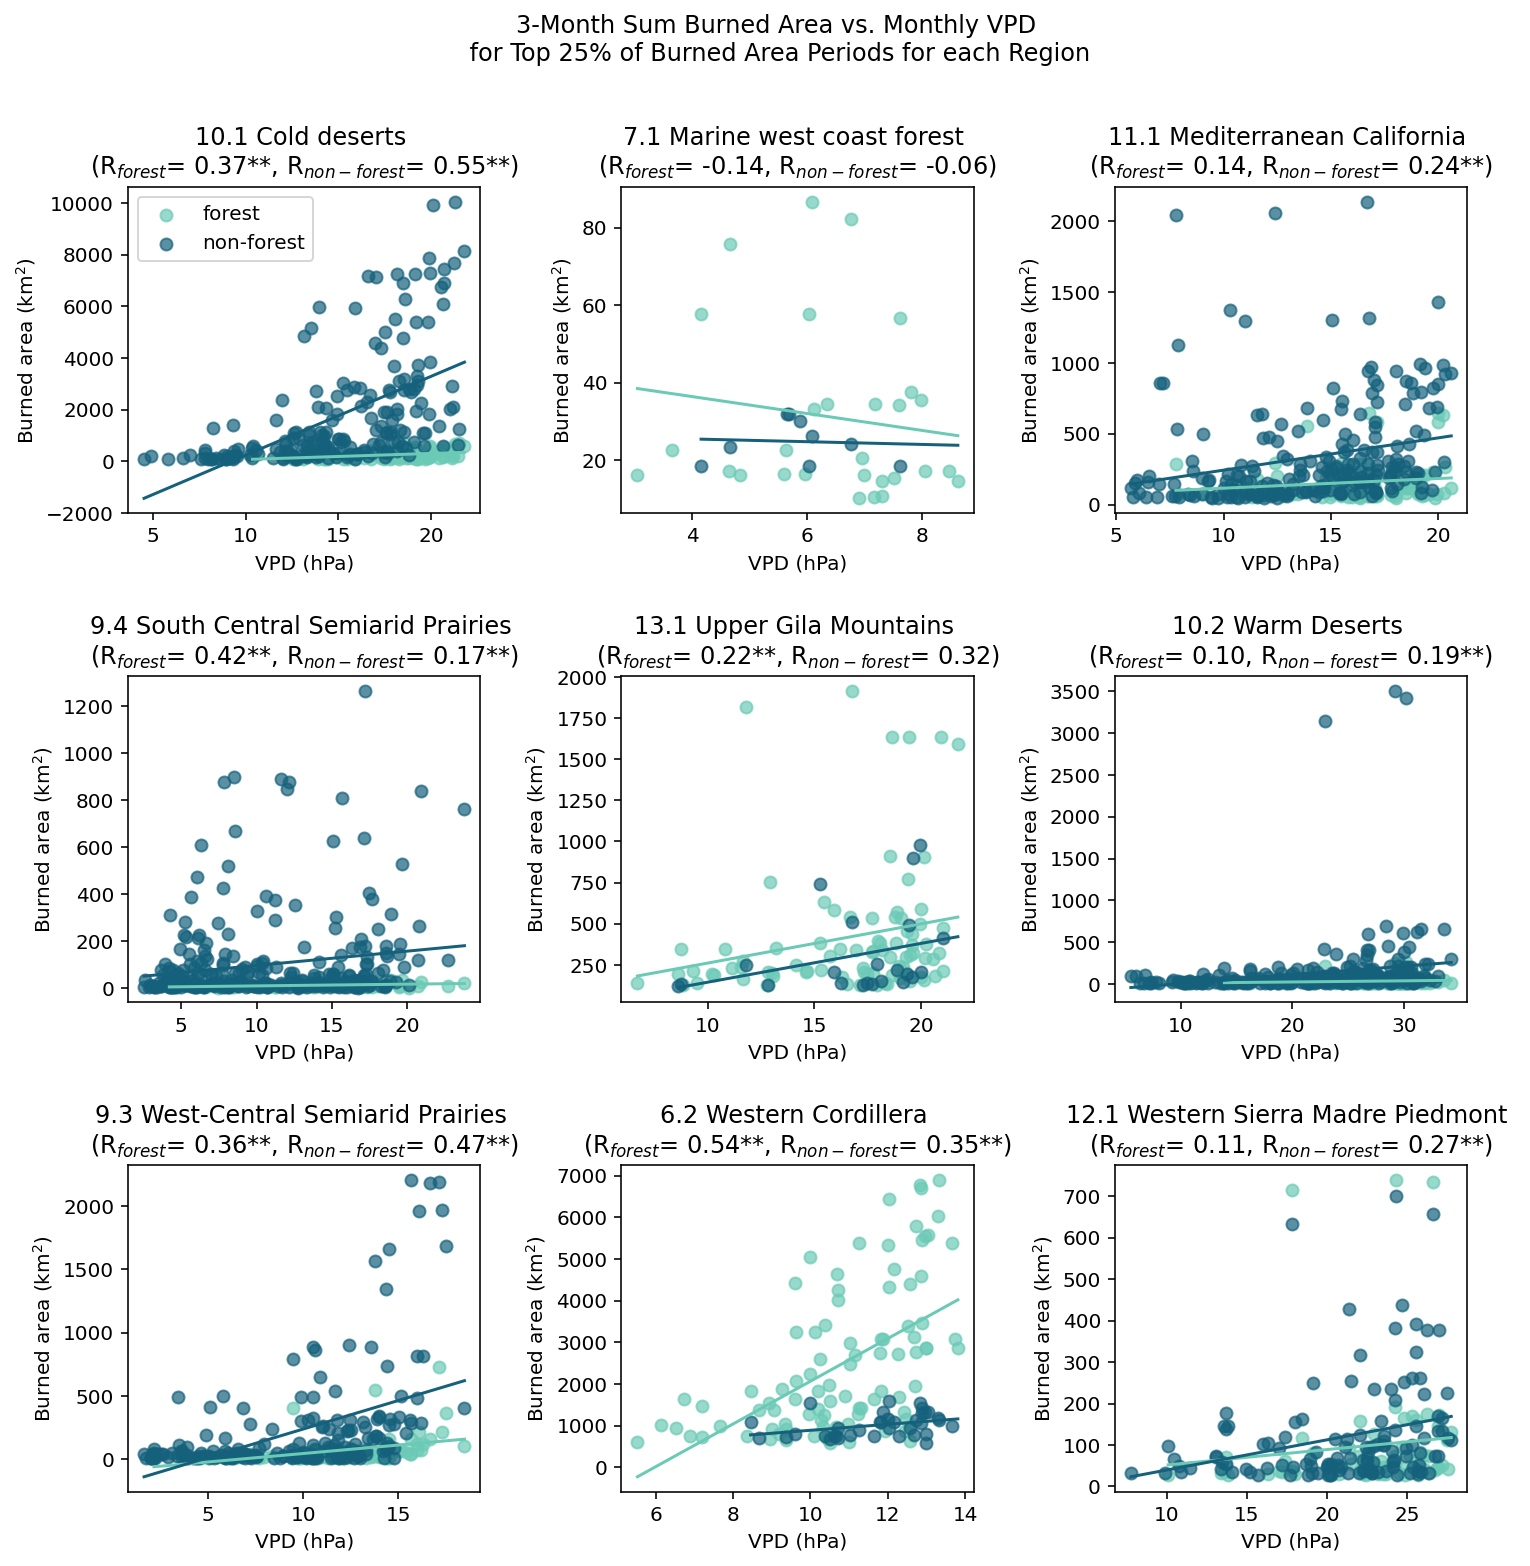

In [25]:
# graph the values

# plot the graph

# plot
fig, ax = plt.subplots(3,3, figsize=(12, 12))

counter = 0
for index in range(0,3):
    for jndex in range(0,3):
        tmpvpd = tmpvpdfo[:, counter].dropna(dim='time')
        tmpburn = tmpburnfo[:, counter].dropna(dim='time')
        tmpvpd2 = tmpvpdxfo[:, counter].dropna(dim='time')
        tmpburn2 = tmpburnxfo[:, counter].dropna(dim='time')
        # create linspace to graph the trendlines
        tmpline = np.linspace(tmpvpd.min(), tmpvpd.max(), 100)
        tmpline2 = np.linspace(tmpvpd2.min(), tmpvpd.max(), 100)
        # plot
        ax[index,jndex].scatter(tmpvpd, tmpburn, color=palette[0], alpha=0.7, label='forest')
        ax[index,jndex].plot(tmpline, (tmpline*mfo[counter] + bfo[counter]), color=palette[0])
        ax[index,jndex].scatter(tmpvpd2, tmpburn2, color=palette[1], alpha=0.7, label='non-forest')
        ax[index,jndex].plot(tmpline2, (tmpline2*mxfo[counter] + bxfo[counter]), color=palette[1])
        counter += 1

# decorate

ax[0,0].set_title('10.1 Cold deserts \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f**)' % (corrfo[0], corrxfo[0]))
ax[0,1].set_title('7.1 Marine west coast forest \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[1], corrxfo[1]))
ax[0,2].set_title('11.1 Mediterranean California \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f**)' % (corrfo[2], corrxfo[2]))
ax[1,0].set_title('9.4 South Central Semiarid Prairies \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f**)' % (corrfo[3], corrxfo[3]))
ax[1,1].set_title('13.1 Upper Gila Mountains \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f)' % (corrfo[4], corrxfo[4]))
ax[1,2].set_title('10.2 Warm Deserts \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f**)' % (corrfo[5], corrxfo[5]))
ax[2,0].set_title('9.3 West-Central Semiarid Prairies \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f**)' % (corrfo[6], corrxfo[6]))
ax[2,1].set_title('6.2 Western Cordillera \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f**)' % (corrfo[7], corrxfo[7]))
ax[2,2].set_title('12.1 Western Sierra Madre Piedmont \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f**)' % (corrfo[8], corrxfo[8]))

for index in range(0,3):
    for jndex in range(0,3):
        ax[index, jndex].set_ylabel('Burned area (km$^2$)')
        ax[index, jndex].set_xlabel('VPD (hPa)')

ax[0,0].legend(loc='upper left')
plt.suptitle('3-Month Sum Burned Area vs. Monthly VPD\n for Top 25% of Burned Area Periods for each Region')
plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.4)
# output
plt.savefig('figures/4burnedarea3monthVPDscatter.png')

## Conclusions
Forest burned area is important to understanding climate-burned area relationships, but non-forest burned area makes up a large part of total burned area in the western US, supporting my hypothesis. There are strong relationships in several ecoregions, particularly in forested mountainous ecoregions and non-forested northern prairies and deserts where the top 25% of 3-month seasonal sums of burned area appear to exponentially increase with their associated 3-month averaged VPD, rejecting my hypothesis that I would see more of a linear relationship. I hope to continue exploring these burned area-VPD relationships.

This study is only preliminary and the strength of the relationships between burned area and VPD may be overestimated, especially if there are years with consecutive months of high burned area that are then included within more than one rolling 3-month period.

Possible future directions include:
* Be more specific about type of vegetation, instead of just forest vs. non-forest
* Vary the quantile (currently is set at top 25%)
* Remove the rolling effect to create discrete seasonal burned area 3-month periods.